In [15]:
# Import the necessary libraries
import pandas as pd

# Read data from the file
interest_rate_df = pd.read_csv('./Resources/Central_Bank_Rates.csv')

# Extract the date columns
date_columns = interest_rate_df.columns[13:]

# Filter and select only the rows for the United States and Australia
filtered_df = interest_rate_df[interest_rate_df['Reference area'].isin(['United States', 'Australia'])]

# Create a new DataFrame with the filtered data
result_df = filtered_df.set_index('Reference area')
# Removed index name
result_df.rename_axis(index={'Reference area': None}, inplace=True)

# Transpose the DataFrame so that countries become rows and dates become columns
result_df = result_df[date_columns].transpose()

# Convert the index to datetime object
result_df.index = pd.to_datetime(result_df.index)
# Filter the DataFrame for dates required
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2023-08-31')  # Assuming August 31st as the end of August
result_df = result_df[(result_df.index >= start_date) & (result_df.index <= end_date)]

# Convert the datetime index to MM-YYYY format
result_df.index = result_df.index.strftime('%m-%Y')

result_df = result_df.drop("Australia", axis=1)
# Reverse the order of the DataFrame index in descending order
result_df = result_df.iloc[::-1]

# Display the filtered DataFrame
result_df


,United States
08-2023,5.375
07-2023,5.375
06-2023,5.125
05-2023,5.125
04-2023,4.875
...,...
05-2010,0.125
04-2010,0.125
03-2010,0.125
02-2010,0.125


<function matplotlib.pyplot.show(close=None, block=None)>

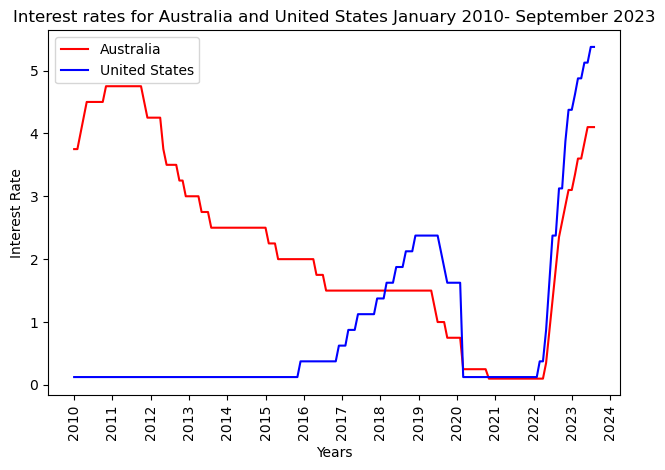

In [10]:
# Code strip for Interest Rates for Australia and United States
# Visualisation

# Required module
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

result_df.index = pd.to_datetime(result_df.index, format='%m-%Y')
# Plot of Australia's interest rates
plt.plot(result_df.index, result_df['Australia'], label = 'Australia', color='red')

# Plot of United States' interest rates
plt.plot(result_df.index, result_df['United States'], label = 'United States', color='blue')

# Title and labels
plt.title('Interest rates for Australia and United States January 2010- September 2023')
plt.xlabel('Years')
plt.ylabel('Interest Rate')

# Use dateformatter to display only the years on the X-Axis
date_format = mdates.DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))

# Rotate the x-labels for readability
plt.xticks(rotation='vertical')

# Add legend
plt.legend()
plt.tight_layout()
plt.show

In [18]:
import nasdaqdatalink as nddl
import pandas as pd

# Set your API key
nddl.ApiConfig.api_key = '-QVCnvjUyqV9eczABr4_'

# Get the Zillow Real Estate Data
median_US_SRAM = nddl.get_table('ZILLOW/DATA', indicator_id='SRAM', region_id='102001')

# Convert 'date' column to datetime and filter by date range
median_US_SRAM['date'] = pd.to_datetime(median_US_SRAM['date'])
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2023-08-31')
median_US_SRAM = median_US_SRAM[(median_US_SRAM['date'] >= start_date) & (median_US_SRAM['date'] <= end_date)]

# Format the 'date' column
median_US_SRAM['date'] = median_US_SRAM['date'].dt.strftime('%m-%Y')

median_US_SRAM = median_US_SRAM.drop(columns=['indicator_id', 'region_id'])


# Rename columns
median_US_SRAM = median_US_SRAM.rename(columns={'date': 'Date', 'value': 'Price'})
median_US_SRAM = median_US_SRAM.set_index('Date')
# Display the filtered data
median_US_SRAM.style.set_properties(**{'text-align': 'center'})
median_US_SRAM


,Price
Date,
08-2023,360000.0
07-2023,362000.0
06-2023,366000.0
05-2023,360000.0
04-2023,350000.0
...,...
05-2010,170280.0
04-2010,167000.0
03-2010,170000.0


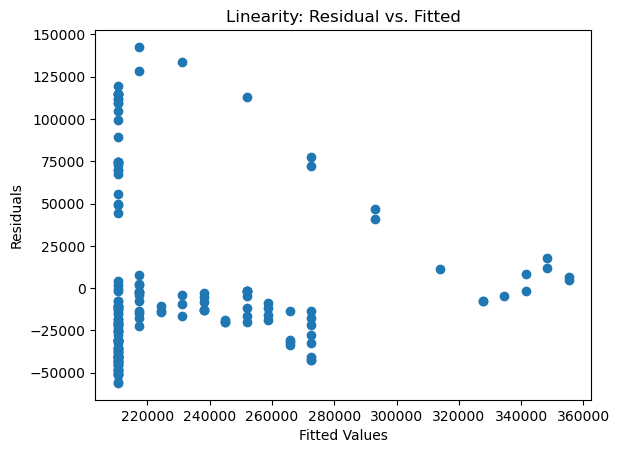

Durbin-Watson Statistic: 0.02823433876948216


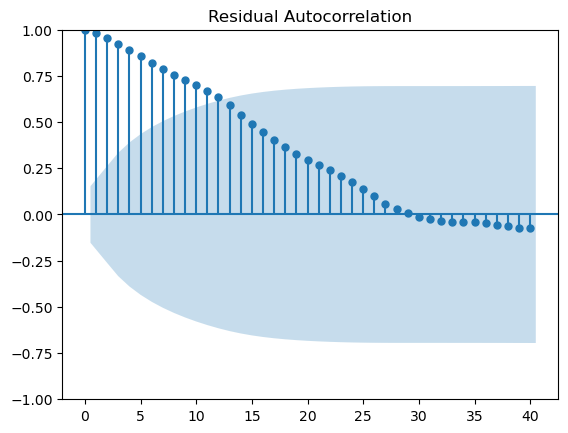

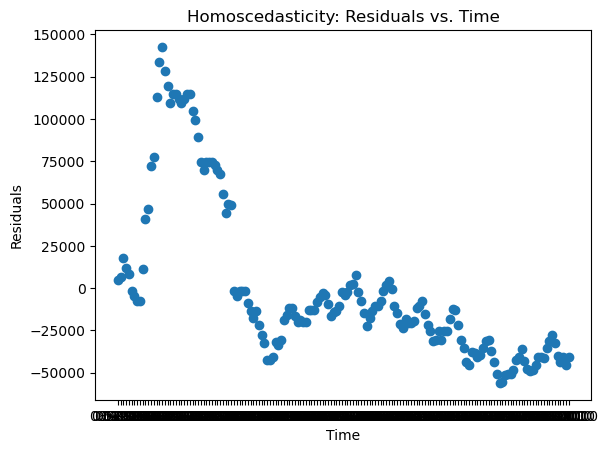

Breusch-Pagan Test p-value: 0.008705650244246172
Ljung-Box Test p-value: l


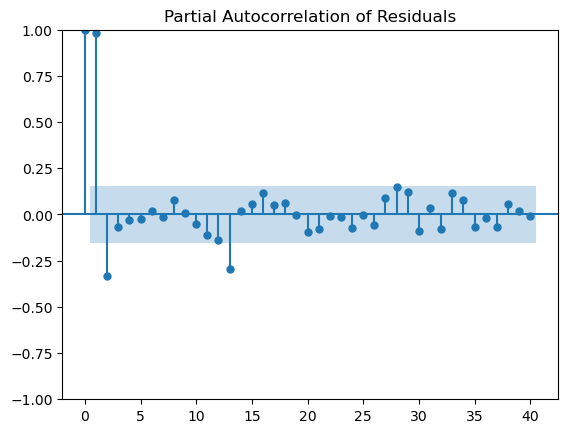

White Test p-value: 0.024201584382879202
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     85.42
Date:                Tue, 17 Oct 2023   Prob (F-statistic):           1.33e-16
Time:                        10:18:57   Log-Likelihood:                -2000.6
No. Observations:                 164   AIC:                             4005.
Df Residuals:                     162   BIC:                             4011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load your data into DataFrames (assuming you have pandas DataFrames)
# df_interest_rates should contain dates and interest rates
# df_property_prices should contain dates and property prices

# Define the dependent variable (property prices) and independent variable (interest rates)
X = result_df['United States']
y = median_US_SRAM['Price']

# Perform the time-series regression analysis
X = sm.add_constant(X) # Add a constant term (intercept)
model = sm.OLS(y, X).fit()

# Linearity: Residual vs. Fitted Plot
residuals = model.resid
fitted_values = model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Linearity: Residual vs. Fitted')
plt.show()

# Independence: Durbin-Watson Test
dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_statistic}')

# Independence: Autocorrelation Plot
plot_acf(residuals, lags=40)
plt.title('Residual Autocorrelation')
plt.show()

# Homoscedasticity: Residuals vs. Time Plot
plt.scatter(median_US_SRAM.index, residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Homoscedasticity: Residuals vs. Time')
plt.show()

# Homoscedasticity: Breusch-Pagan Test
het_breuschpagan_results = het_breuschpagan(residuals, X)
print(f'Breusch-Pagan Test p-value: {het_breuschpagan_results[1]}')

# No Autocorrelation: Ljung-Box Test
lb_statistic, lb_pvalue = sm.stats.acorr_ljungbox(residuals, lags=[10])
print(f'Ljung-Box Test p-value: {lb_pvalue[0]}')

# Partial Autocorrelation Function Plot
plot_pacf(residuals, lags=40)
plt.title('Partial Autocorrelation of Residuals')
plt.show()

# White Test for Heteroscedasticity
white_test_results = het_white(residuals, X)
print(f'White Test p-value: {white_test_results[1]}')

# Display regression results
print(model.summary())

The regression results you've provided show the output of an Ordinary Least Squares (OLS) regression model. This model examines the relationship between interest rates in the United States and property prices. The Null Hypothesis (H0) in this context can be reworded as "Interest rates do not have a statistically significant effect on property prices," and the Alternative Hypothesis (H1) can be reworded as "Interest rates have a statistically significant effect on property prices."

Here's an interpretation of the key elements of the regression results:

1. **R-squared (R²)**: R-squared measures the goodness of fit of the model, representing the proportion of the variance in the dependent variable (property prices) that can be explained by the independent variable (interest rates). An R-squared value of 0.345 indicates that approximately 34.5% of the variation in property prices can be explained by changes in interest rates. This suggests that interest rates have some influence on property prices, but there are other factors at play as well.

2. **F-statistic**: The F-statistic tests the overall significance of the regression model. In this case, the F-statistic is 85.42, and the associated p-value is very close to zero (1.33e-16). This low p-value indicates that the model as a whole is statistically significant, implying that at least one of the independent variables (interest rates) has a significant impact on the dependent variable (property prices).

3. **Coefficients**:
   - The coefficient of the "const" term is approximately 2.07e+05. This represents the estimated property price when the United States interest rate is zero. In practical terms, it's the intercept of the regression line.
   - The coefficient for "United States" interest rates is approximately 2.758e+04. This suggests that for each unit increase in United States interest rates, property prices are estimated to increase by approximately 27,580 units.

4. **P-values**:
   - The p-value associated with the "United States" interest rates coefficient is very close to zero, indicating that the interest rates variable is statistically significant. This supports the Alternative Hypothesis (H1) that interest rates have a statistically significant effect on property prices.

5. **Omnibus, Durbin-Watson, Jarque-Bera, Skew, Kurtosis**:
   - These statistics are used to assess the assumptions of the regression model. An important point to note is the very low Durbin-Watson statistic (close to zero), which suggests potential issues with autocorrelation in the residuals, meaning that the errors may not be independent over time. This could affect the reliability of the model.

6. **Notes**:
   - The standard errors assume that the covariance matrix of the errors is correctly specified. This is an assumption of the OLS model.

In summary, the regression results indicate that United States interest rates are statistically significant in explaining variations in property prices, as the p-value associated with the "United States" interest rates coefficient is very close to zero. However, the low R-squared value suggests that while interest rates play a role, they don't explain the entirety of the variation in property prices, and other factors likely contribute as well. The low Durbin-Watson statistic raises concerns about potential autocorrelation in the model's residuals, which may need further investigation or correction.

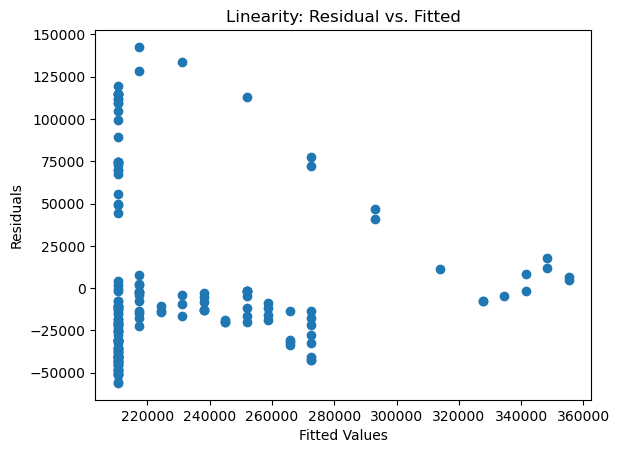

Durbin-Watson Statistic: 0.02823433876948216


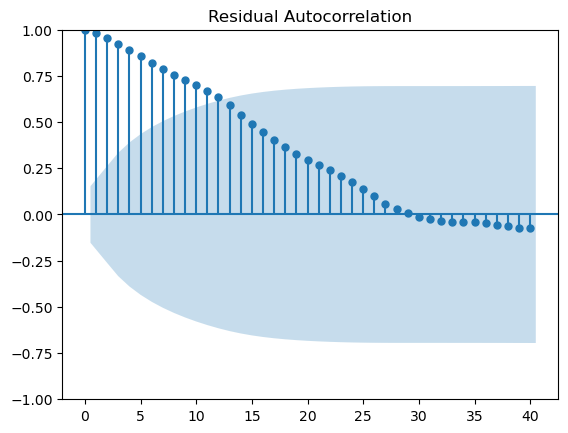

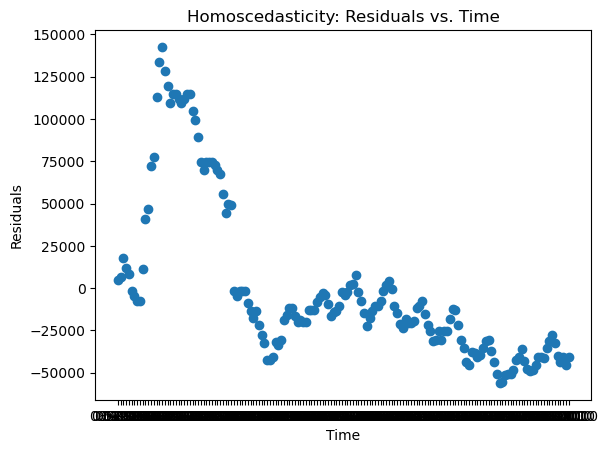

Breusch-Pagan Test p-value: 0.008705650244246172
Ljung-Box Test p-value: l


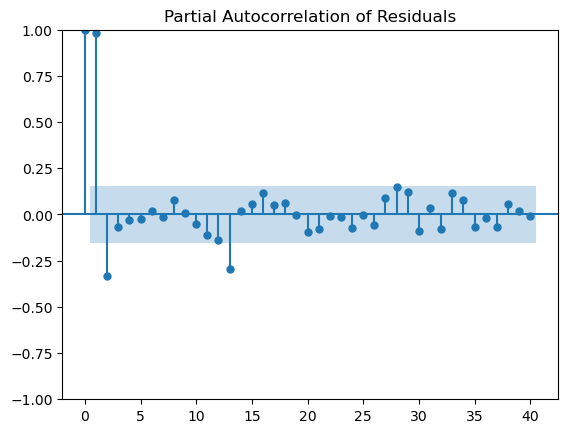

White Test p-value: 0.024201584382879202
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     85.42
Date:                Tue, 17 Oct 2023   Prob (F-statistic):           1.33e-16
Time:                        10:34:29   Log-Likelihood:                -2000.6
No. Observations:                 164   AIC:                             4005.
Df Residuals:                     162   BIC:                             4011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load your data into DataFrames (assuming you have pandas DataFrames)
# df_interest_rates should contain dates and interest rates
# df_property_prices should contain dates and property prices

# Define the dependent variable (property prices) and independent variable (interest rates)
X = result_df['United States']
y = median_US_SRAM['Price']


# Perform the time-series regression analysis
X = sm.add_constant(X)  # Add a constant term (intercept)
model = sm.OLS(y, X).fit()

# Linearity: Residual vs. Fitted Plot
residuals = model.resid
fitted_values = model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Linearity: Residual vs. Fitted')
plt.show()

# Independence: Durbin-Watson Test
dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_statistic}')

# Independence: Autocorrelation Plot
plot_acf(residuals, lags=40)
plt.title('Residual Autocorrelation')
plt.show()

# Homoscedasticity: Residuals vs. Time Plot
plt.scatter(median_US_SRAM.index, residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Homoscedasticity: Residuals vs. Time')
plt.show()

# Homoscedasticity: Breusch-Pagan Test
het_breuschpagan_results = het_breuschpagan(residuals, X)
print(f'Breusch-Pagan Test p-value: {het_breuschpagan_results[1]}')

# No Autocorrelation: Ljung-Box Test
lb_statistic, lb_pvalue = sm.stats.acorr_ljungbox(residuals, lags=[10])
print(f'Ljung-Box Test p-value: {lb_pvalue[0]}')

# Partial Autocorrelation Function Plot
plot_pacf(residuals, lags=40)
plt.title('Partial Autocorrelation of Residuals')
plt.show()

# White Test for Heteroscedasticity
white_test_results = het_white(residuals, X)
print(f'White Test p-value: {white_test_results[1]}')

# Display regression results
print(model.summary())


In [54]:
import pandas as pd
import statsmodels.api as sm

# Load your time-ordered data into a DataFrame
# Ensure that the DataFrame includes a datetime index


# Define your independent variable (interest rates)
X = result_df['United States']

# Add a constant (intercept) to the independent variable
X = sm.add_constant(X)

# Define your dependent variable (property prices)
y = median_US_SRAM['Price']

# Fit the time-series regression model
model = sm.OLS(y, X).fit()

# Get summary statistics, including p-values
summary = model.summary()

# Extract the p-value for the coefficient of the interest rates
table = summary.tables[1]
table

# Extract the p-value for the coefficient of the interest rates
p_value_interest_rates = table.data[2][4]

# Set your significance level (e.g., 0.05)
alpha = 0.05

# Hypothesis testing based on p-value
if float(p_value_interest_rates) < alpha:
    print("Reject the null hypothesis. Interest rates have a statistically significant effect on property prices.")
else:
    print("Fail to reject the null hypothesis. Interest rates do not have a statistically significant effect on property prices.")
print(p_value_interest_rates)
print(model.summary())

Reject the null hypothesis. Interest rates have a statistically significant effect on property prices.
 0.000
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     85.42
Date:                Tue, 17 Oct 2023   Prob (F-statistic):           1.33e-16
Time:                        11:10:13   Log-Likelihood:                -2000.6
No. Observations:                 164   AIC:                             4005.
Df Residuals:                     162   BIC:                             4011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [55]:
import pandas as pd
import statsmodels.api as sm

# Define your independent variable (interest rates)
X = result_df['United States']

# Add a constant (intercept) to the independent variable
X = sm.add_constant(X)

# Define your dependent variable (property prices)
y = median_US_SRAM['Price']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Get the p-value for the coefficient of the interest rates
p_value_interest_rates = model.pvalues['United States']

# Print the p-value
print(f"P-value for the 'United States' coefficient: {p_value_interest_rates}")

# Set your significance level (e.g., 0.05)
alpha = 0.05

# Hypothesis testing based on p-value
if p_value_interest_rates < alpha:
    print("Reject the null hypothesis. Interest rates have a statistically significant effect on property prices.")
else:
    print("Fail to reject the null hypothesis. Interest rates do not have a statistically significant effect on property prices.")
print(model.summary())

P-value for the 'United States' coefficient: 1.332086825740731e-16
Reject the null hypothesis. Interest rates have a statistically significant effect on property prices.
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     85.42
Date:                Tue, 17 Oct 2023   Prob (F-statistic):           1.33e-16
Time:                        11:10:45   Log-Likelihood:                -2000.6
No. Observations:                 164   AIC:                             4005.
Df Residuals:                     162   BIC:                             4011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err     

In [56]:
import scipy.stats as stats

# Degrees of Freedom
Df_Model = 1  # Replace with the actual degrees of freedom for the model
Df_Residuals = 162  # Replace with the actual degrees of freedom for the residuals

# Significance Level (alpha)
alpha = 0.05  # Change this to your desired significance level

# Calculate the critical F-value
critical_f_value = stats.f.ppf(1 - alpha, Df_Model, Df_Residuals)

print(f"Critical F-value at alpha = {alpha}: {critical_f_value}")


Critical F-value at alpha = 0.05: 3.899502435176602


85.42 is much larger than 3.8995, it indicates that the model is statistically significant at the 0.05 significance level. This suggests that at least one of the independent variables in your model has a statistically significant effect on the dependent variable (property prices). This is a strong indication that the regression model is meaningful and that the independent variables collectively explain a significant portion of the variation in property prices.

In [ ]:
# Code for Crit-F

# Degrees of Freedom
Df_Model = 1  # Replace with the actual degrees of freedom for the model
Df_Residuals = 162  # Replace with the actual degrees of freedom for the residuals

# Significance Level (alpha)
alpha = 0.05  # Change this to your desired significance level

# Calculate the critical F-value
critical_f_value = stats.f.ppf(1 - alpha, Df_Model, Df_Residuals)



# Code for Regression Analysis

# Define your independent variable (interest rates)
X = new_filtered_interest_rates_df['United States']

# Add a constant (intercept) to the independent variable
X = sm.add_constant(X)

# Define your dependent variable (property prices)
y = filtered_median_US_SRAM['Median Sale Price (Raw, All Homes, Monthly)']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Get the p-value for the coefficient of the interest rates
p_value_interest_rates = model.pvalues['United States']

# Null and Alt Hypotheses
print("Null Hypothesis (H0):")
print("There is no statistically significant relationship between changes in interest rates and property prices in the United States.\n")
print("Alternative Hypothesis (H1):")
print("There is a statistically significant relationship between changes in interest rates and property prices in the United States.\n")

# Print the p-value
print(f"P-value for the 'interest rate' coefficient: {p_value_interest_rates}")

# Set your significance level (e.g., 0.05)
alpha = 0.05

print(f"Critical F-value at alpha = {alpha}: {critical_f_value}")



# Hypothesis testing based on p-value
if p_value_interest_rates < alpha:
    print("\nReject the null hypothesis. Interest rates have a statistically significant effect on property prices.\n")
else:
    print("\nFail to reject the null hypothesis. Interest rates do not have a statistically significant effect on property prices.\n")
print(model.summary())

